# Convergence of the estimation of the rotation

In [1]:
%matplotlib inline
import numpy as onp
import jax.numpy as np
from jax.ops import index, index_update
from jax.config import config
from numpy.random import default_rng
from scipy.stats import multivariate_normal as mvn

from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme('talk', 'darkgrid')

plt.rcParams["figure.figsize"] = (15,4)

config.update("jax_enable_x64", True)

seed = 0
rng = default_rng(seed)

In [2]:
# Functions
isqrt = lambda x: 1. / np.sqrt(x)
funs = {'sqrt': np.sqrt,
        'isqrt': isqrt,
        'log': np.log,
        'exp': np.exp}

def norm_frob_squared(X):
    return np.einsum('...ji,...ji', X, X)

def dist_frob_squared(X, Y):
    return norm_frob_squared(X - Y)

def transform_mat(X, func='sqrt'):
    u, v = np.linalg.eigh(X)
    return np.einsum('...ij,...j,...kj', v, funs[func](u), v)

def dist_riem_squared(X, Y):
    x = transform_mat(X, 'isqrt')
    mid = np.einsum('...ij,...jk,...kl', x, Y, x)
    return norm_frob_squared(transform_mat(mid, 'log'))

def costfunc(X, Y):
    return np.sum(dist_riem_squared(X, Y))

def costfuncproc(X, Y):
    return np.sum(dist_frob_squared(X, Y))

def rotate(X, Omega):
    return np.einsum('...ij,...jk,...lk', Omega, X, Omega)

def optimal_rotation(X, M):
    _, g_m = np.linalg.eigh(M)
    _, g_x = np.linalg.eigh(X)
    return np.einsum('...ij,...kj', g_m, g_x)

def optimal_reference_eigval(X):
    u = np.linalg.eigvalsh(X)
    return np.power(np.prod(u, axis=0), 1 / X.shape[0])

def optimal_reference_eigvec(X):
    _, vs = np.linalg.eigh(X)
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    return np.einsum('...ij,...jk', U, V)

def optimal_reference(X):
    u, vs = np.linalg.eigh(X)
    Lam = np.power(np.prod(u, axis=0), 1 / X.shape[0])
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    Gam = np.einsum('...ij,...jk', U, V)
    return np.einsum('...ij,...j,...kj', Gam, Lam, Gam)

def emp_cov(data):
    l, p = data.shape
    mn = data.mean(axis=0)
    data = data - mn
    return (data.T @ data) / l

# Consistency of rotation between two matrices


  0%|          | 0/50 [00:00<?, ?it/s]

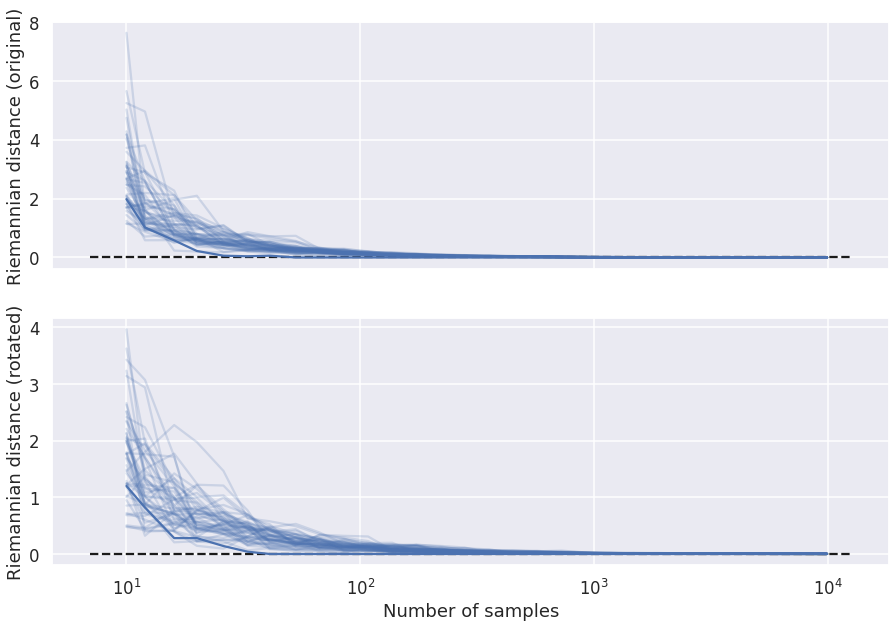

In [5]:
# Hyperparameters:
p = 3
m = 10
rep = 50
datapoints = 32
ns = np.logspace(0.9, 4.1, datapoints, dtype=int)

# True values
Sigma_one = np.array(rng.normal(size=(p, p)))
Sigma_one = Sigma_one @ Sigma_one.T
TrueMean = np.zeros(shape=(p))
TrueRotation = np.linalg.qr(rng.normal(size=(p, p)))[0]
Sigma_two = rotate(Sigma_one, TrueRotation)


f, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15, 10))
ax[0].hlines(y=0, xmin=ns.min(), xmax=ns.max(), colors='k', linestyles='--')
ax[1].hlines(y=0, xmin=ns.min(), xmax=ns.max(), colors='k', linestyles='--')

dists_one_mean = np.zeros_like(ns)
dists_two_mean = np.zeros_like(ns)
data = pd.DataFrame({'Number of samples': ns, 
                     'Riemannian distance (original)': dists_one_mean,
                     'Riemannian distance (rotated)': dists_two_mean,
                     })


for _ in trange(rep):
    dists_one = []
    dists_two = []
    for k, n in enumerate(ns):
        data_one = np.array(mvn.rvs(mean=TrueMean, cov=Sigma_one, size=n))
        data_two = np.array(mvn.rvs(mean=TrueMean, cov=Sigma_two, size=n))

        Sigma_emp_one = emp_cov(data_one)
        Sigma_emp_two = emp_cov(data_two)

        Rotation_emp = optimal_rotation(Sigma_emp_two, Sigma_emp_one)
                
        dists_one.append(dist_riem_squared(Sigma_emp_one, Sigma_one))
        dists_two.append(dist_riem_squared(rotate(Sigma_emp_two, Rotation_emp), Sigma_emp_one))
        
        dists_one_mean = index_update(dists_one_mean, k, dists_one_mean[k] + dists_one[k])
        dists_two_mean = index_update(dists_two_mean, k, dists_two_mean[k] + dists_two[k])
        
    data['Riemannian distance (original)'] = dists_one
    data['Riemannian distance (rotated)'] = dists_two
        
    dtmp = data[['Riemannian distance (original)', 'Riemannian distance (rotated)']].rolling(window=3, center=True).mean()
    data[['Riemannian distance (original)', 'Riemannian distance (rotated)']] = dtmp.reset_index()[['Riemannian distance (original)', 'Riemannian distance (rotated)']]

    sns.lineplot(data=data,
                 x='Number of samples',
                 y='Riemannian distance (original)',
                 ax=ax[0],
                 color='b',
                 alpha=0.2
                )

    sns.lineplot(data=data,
                 x='Number of samples',
                 y='Riemannian distance (rotated)',
                 ax=ax[1],
                 color='b',
                 alpha=0.2
                )

sns.lineplot(x=ns[1:-1], y=dists_one_mean[1:-1]/rep, ax=ax[0], color='b')
sns.lineplot(x=ns[1:-1], y=dists_two_mean[1:-1]/rep, ax=ax[1], color='b')
plt.xscale('log')
plt.show()

# Simulation with $M$ matrices

We generate $M$ matrices $p\times p$ (which represents the *true* covariances for the $M$ subjects) $\Sigma_m$.
Then, for each subject, we generate a dataset of $n_m$ samples from a multivariate normal $\mathcal{N}_p\left(\mathbf{0}, \Sigma_m\right)$ and we compute the empirical covariance matrices $\hat\Sigma_m$ and their eigenvalue decompositions $\Gamma_m\Lambda_m\Gamma_m^\top$.

We then compute the optimal reference matrix $\mathbf{R}$ that has eigenvalues $\Lambda_h^\mathbf{R} = \left[\prod_m^M\lambda_h^m\right]^{\frac{1}{M}}$ and eigenvectors $\Gamma_\mathbf{R}=\mathbf{U}\mathbf{V}^\top$ with $\mathbf{U}\mathbf{D}\mathbf{V}^\top = \sum_m^M\Gamma_m$ the singular value decomposition of the sum of the eigenvector decompositions.

Finally, we rotate each $\hat\Sigma_m$ with the optimal rotation $\Omega_m=\Gamma_\mathbf{R}\Gamma_m^\top$.

To check for the consistency of this procedure, we compare the sum of the pairwise distances $\sum_{m,k}^Md(\Sigma_m, \Sigma_k)$ between the empirical covariances and the true covariances, both for the original matrices and for the rotated ones. As known, the empirical covariance is a consistent estimator of the true covariance for a multivariate normal, and the distance between the matrices should maintain this consistency. Moreover, the same should happen for the matrices in the rotated space

Pairwise distances True:			 3082.9495947265286
Pairwise distances True Rotated:		 1253.881113309059


  0%|          | 0/50 [00:00<?, ?it/s]

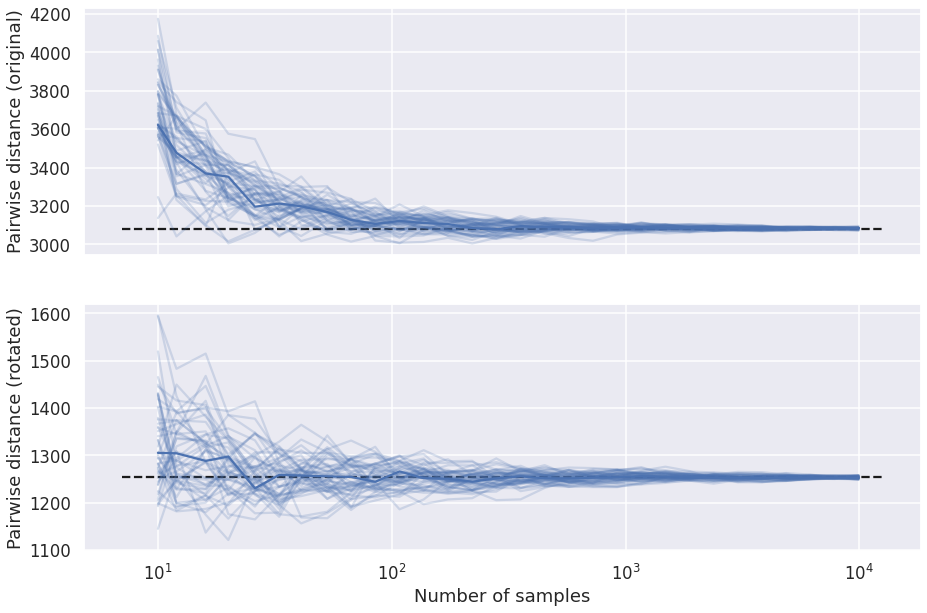

In [6]:
# Hyperparameters:
p = 3
m = 10
rep = 50
datapoints = 32
ns = np.logspace(0.9, 4.1, datapoints, dtype=int)

# Generate true subject covariances
# TODO: use von Mises - Fisher instead of uniform
Sigmas = np.array(rng.normal(size=(m, p, p)))
Sigmas = np.einsum('...ij,...kj', Sigmas, Sigmas)
Means = np.zeros(shape=(m, p))

# Generate the dataset and compute the empirical covariances

def emp_cov(data):
    mn = np.expand_dims(data.mean(axis=1), axis=1)
    data = data - mn
    return np.einsum('...ji,...jk', data, data) / data.shape[-2]

def costfunc(X, Y):
    d = 0
    for i, y in enumerate(Y):
        x = np.delete(X, i, axis=0)
        d += np.sum(dist_riem_squared(x, y))
    return d

# Determine the optimal reference matrix
Ref = optimal_reference(Sigmas)
# Perform the rotations
Sigmas_rot = rotate(Sigmas, optimal_rotation(Sigmas, Ref))
# Compute the distances
dists_ori = costfunc(Sigmas, Sigmas)
dists_rot = costfunc(Sigmas_rot, Sigmas_rot)
print("Pairwise distances True:\t\t\t", dists_ori)
print("Pairwise distances True Rotated:\t\t", dists_rot)

#dists_ori_emp = []
#dists_rot_emp = []

f, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15, 10))
ax[0].hlines(y=dists_ori, xmin=ns.min(), xmax=ns.max(), colors='k', linestyles='--')
ax[1].hlines(y=dists_rot, xmin=ns.min(), xmax=ns.max(), colors='k', linestyles='--')

data = pd.DataFrame({'Number of samples': ns, 
                     'Pairwise distance (original)': dists_ori,
                     'Pairwise distance (rotated)': dists_rot,
                     })
dists_ori_mean = np.zeros_like(ns)
dists_rot_mean = np.zeros_like(ns)

for _ in trange(rep):
    dists_ori_emp = []
    dists_rot_emp = []
    for k, n in enumerate(ns):
        datasets = np.array([mvn.rvs(mean=Means[i], cov=Sigmas[i], size=n) for i in range(m)])
        Sigmas_emp = emp_cov(datasets)

        # Determine the optimal reference matrix
        Ref_emp = optimal_reference(Sigmas_emp)

        # Perform the rotations
        Sigmas_rot_emp = rotate(Sigmas_emp, optimal_rotation(Sigmas_emp, Ref_emp))

        # Compute the distances
        dists_ori_emp.append(costfunc(Sigmas_emp, Sigmas_emp))
        dists_rot_emp.append(costfunc(Sigmas_rot_emp, Sigmas_rot_emp))
        
        dists_ori_mean = index_update(dists_ori_mean, k, dists_ori_mean[k] + dists_ori_emp[k])
        dists_rot_mean = index_update(dists_rot_mean, k, dists_rot_mean[k] + dists_rot_emp[k])

        #print("\tPairwise distances Empirical ({}):\t\t{}".format(n, dists_ori_emp[-1]))
        #print("\tPairwise distances Empirical Rotated ({}):\t{}".format(n, dists_rot_emp[-1]))
    data['Pairwise distance (original)'] = dists_ori_emp
    data['Pairwise distance (rotated)'] = dists_rot_emp
        
    dtmp = data[['Pairwise distance (original)', 'Pairwise distance (rotated)']].rolling(window=3, center=True).mean()
    data[['Pairwise distance (original)', 'Pairwise distance (rotated)']] = dtmp.reset_index()[['Pairwise distance (original)', 'Pairwise distance (rotated)']]

    sns.lineplot(data=data,
                 x='Number of samples',
                 y='Pairwise distance (original)',
                 ax=ax[0],
                 color='b',
                 alpha=0.2
                )

    sns.lineplot(data=data,
                 x='Number of samples',
                 y='Pairwise distance (rotated)',
                 ax=ax[1],
                 color='b',
                 alpha=0.2
                )
sns.lineplot(x=ns[1:-1], y=dists_ori_mean[1:-1]/rep, ax=ax[0], color='b')
sns.lineplot(x=ns[1:-1], y=dists_rot_mean[1:-1]/rep, ax=ax[1], color='b')
plt.xscale('log')
plt.show()